In [1]:
### Please, notice that this code has been adapted from 
###https://machinelearningmastery.com/simulated-annealing-from-scratch-in-python/

import numpy as np
import matplotlib.pyplot as plt

def generate_rand_points(N,bounds):
    points=np.random.rand(N,bounds.shape[0])
    scales=np.diff(bounds,1).flatten()
    offsets=bounds[:,[0]].flatten()
    return points*scales+offsets

## UTILITIES

def Within_Boundary(point,bounds):
    ##Check if a point lies inside a rectangular boundary.
    ##
    ##Args:
    ##    point (list or tuple): Coordinates of the point to be projected.
    ##    bounds (list of lists): Rectangular boundary defined as [[x_low, x_up], [y_low, y_up]].
    ##    
    ##Returns:
    ##    boolean answering: is the point inside the domain?
    
    scales=np.diff(bounds,1).flatten()
    offsets=bounds[:,[0]].flatten()
    within = (offsets <= point) & (point <= offsets + scales.flatten())
    return within.all()

def PeriodicBoundaryConditions(point, boundary):
    
    ##Project a point back inside a rectangular boundary with periodic boundary conditions.
    ##
    ##Args:
    ##    point (list or tuple): Coordinates of the point to be projected.
    ##    boundary (list of lists): Rectangular boundary defined as [[x_low, x_up], [y_low, y_up]].
    ##   
    ##Returns:
    ##    projected_point (list): Projected coordinates of the point.
    
    # Extract boundary limits
    x_low, x_up = boundary[0]
    y_low, y_up = boundary[1]
    
    # Extract point coordinates
    x, y = point
    
    # Apply periodic boundary conditions
    width_x = x_up - x_low
    width_y = y_up - y_low
    
    while x < x_low:
        x += width_x
    while x >= x_up:
        x -= width_x
    
    while y < y_low:
        y += width_y
    while y >= y_up:
        y -= width_y
    
    # Return the projected point
    projected_point = np.array([x, y])
    return projected_point


# simulated annealing algorithm
def SO_simulated_annealing(objective, bounds, n_iterations, step_size, temp):
    # generate an initial point
    best = bounds[:, 0] + np.random.rand(len(bounds)) * (bounds[:, 1] - bounds[:, 0])
    # evaluate the initial point
    best_eval = objective(best)
    # current working solution
    curr, curr_eval = best, best_eval
    # list keeping track of the evolution
    scores=[curr_eval]
    points=[best]
    bests=[curr_eval]
    # run the algorithm
    for i in range(n_iterations):
        # take a step
        candidate = curr + np.random.randn(len(bounds)) * step_size
        #check it is within boundary, if not apply Periodic bounday conditions
        candidate = PeriodicBoundaryConditions(candidate,bounds)
        # evaluate candidate point
        candidate_eval = objective(candidate)
        # calculate temperature for current epoch
        t = temp / float(i + 1)
        # check for new best solution
        if candidate_eval < best_eval:
            # store new best point
            best, best_eval = candidate, candidate_eval
            # keep track of scores and points
            bests.append(best_eval)
            # report progress
            print('>%d f(%s) = %.5f' % (i, best, best_eval))
        # difference between candidate and current point evaluation
        diff = candidate_eval - curr_eval
        # calculate metropolis acceptance criterion
        metropolis = np.exp(-diff / t)
        # check if we should keep the new point
        if np.random.rand() < metropolis:
            # store the new current point
            curr, curr_eval = candidate, candidate_eval
            # keep track of scores and points
            scores.append(curr_eval)
            points.append(curr)
            
    points = np.stack(points,0)
    hist={'scores':scores,
          'points': points,
          'best':bests}
    return best, best_eval, hist



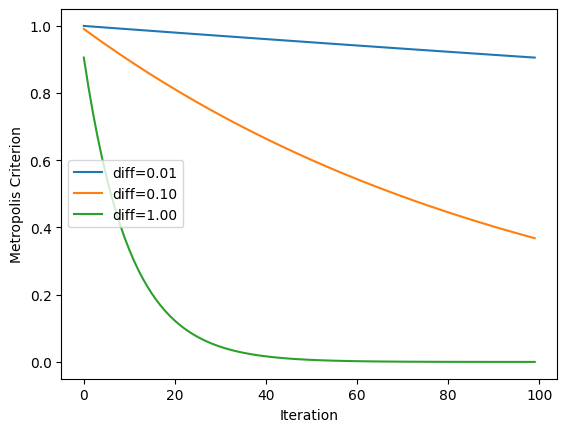

In [2]:
# explore metropolis acceptance criterion for simulated annealing

# total iterations of algorithm
iterations = 100
# initial temperature
initial_temp = 10
# array of iterations from 0 to iterations - 1
iterations = [i for i in range(iterations)]
# temperatures for each iterations
temperatures = [initial_temp/float(i + 1) for i in iterations]
# metropolis acceptance criterion
differences = [0.01, 0.1, 1.0]
for d in differences:
    metropolis = [np.exp(-d/t) for t in temperatures]
    # plot iterations vs metropolis
    label = 'diff=%.2f' % d
    plt.plot(iterations, metropolis, label=label)
# inalize plot
plt.xlabel('Iteration')
plt.ylabel('Metropolis Criterion')
plt.legend()
plt.show()

>0 f([ 1.4464506  -0.89086848]) = 0.28551
>5 f([ 1.72697252 -0.71245555]) = -0.13691
>16 f([ 1.69552454 -0.85535436]) = -0.17229
>83 f([ 1.67683712 -0.82130738]) = -0.20096
>138 f([ 1.67659525 -0.81878602]) = -0.20232
>194 f([ 1.721614   -0.80227534]) = -0.21194
>637 f([ 1.72101908 -0.79435074]) = -0.21241
>643 f([ 1.71043175 -0.79468243]) = -0.21498
>6081 f([ 1.69995617 -0.7906624 ]) = -0.21503
>6684 f([ 1.70808203 -0.79278741]) = -0.21513
>10800 f([ 1.70262062 -0.79261711]) = -0.21532
>13036 f([ 1.70110923 -0.79442661]) = -0.21538
>13710 f([ 1.70587732 -0.79503301]) = -0.21540
>14004 f([ 1.70336015 -0.79755896]) = -0.21544
>31661 f([ 1.70310159 -0.7960955 ]) = -0.21546
Done!
f([ 1.70310159 -0.7960955 ]) = -0.215461


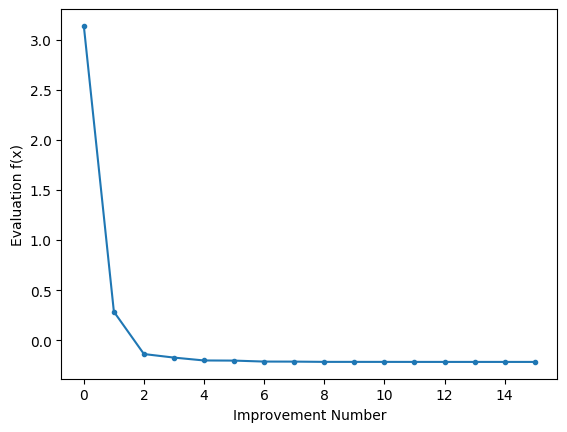

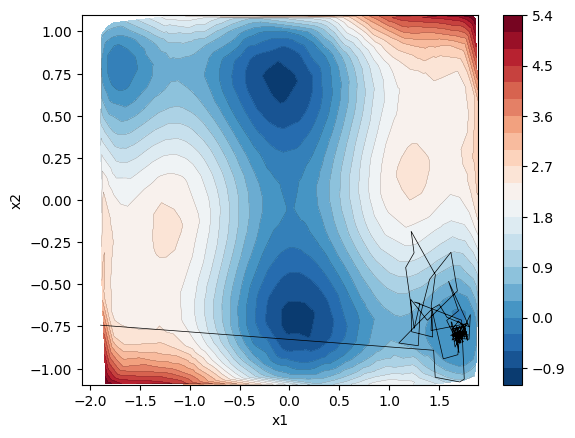

In [3]:

def objective_6hump_camelback(x):
    if len(x.shape)==2:
        return 4*x[:,0]**2-4*x[:,1]**2 + x[:,0]*x[:,1] -2.1*x[:,0]**4+4*x[:,1]**4 +x[:,0]**6/3
    elif len(x.shape)==1:
        return 4*x[0]**2-4*x[1]**2 + x[0]*x[1] -2.1*x[0]**4+4*x[1]**4 +x[0]**6/3


objective=objective_6hump_camelback

# seed the pseudorandom number generator
#np.random.seed(2)
# define range for input
bounds = np.array([[-1.9, 1.9],[-1.1, 1.1]])
# define the total iterations
n_iterations = 100000
# define the maximum step size
step_size = 0.2
# initial temperature
temp = 10
# perform the simulated annealing search
best, score, hist = SO_simulated_annealing(objective, bounds, n_iterations, step_size, temp)
scores=hist['best']
print('Done!')
print('f(%s) = %f' % (best, score))
# line plot of best scores
plt.plot(scores, '.-')
plt.xlabel('Improvement Number')
plt.ylabel('Evaluation f(x)')
plt.show()



## Plot trajectory in the ojective space and isocurves
## to monitor the qualitiy of the evolution
N=1000
points=generate_rand_points(N,bounds)
f_points=objective(points)

fig, ax = plt.subplots(nrows=1)
ax.tricontour(points[:,0], points[:,1], f_points, levels=24, linewidths=0.1, colors='k')
cntr2 = ax.tricontourf(points[:,0], points[:,1], f_points, levels=24 , cmap="RdBu_r")
fig.colorbar(cntr2, ax=ax)
ax.plot(hist['points'][:,0],hist['points'][:,1], linewidth=0.5, color='k')
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

### Multi-objective Simulated Annealing

In [10]:
def dominates(f1,f2):
    f1=np.array(f1)
    f2=np.array(f2)
    return np.all(f1<=f2) and np.any(f1<f2)


# simulated annealing algorithm
def MO_simulated_annealing(objective_list, bounds, n_iterations, step_size, temp, verbose=True):
    # generate an initial point
    best = bounds[:, 0] + np.random.rand(len(bounds)) * (bounds[:, 1] - bounds[:, 0])
    # evaluate the initial point
    best_eval = [objective(best) for objective in objective_list]
    # current working solution
    curr, curr_eval = best, best_eval
    scores=[curr_eval]
    points=[best]
    bests=[curr_eval]
    # run the algorithm
    for i in range(n_iterations):
        # take a step within the boundary
        candidate = curr + np.random.randn(len(bounds)) * step_size
        while not Within_Boundary(candidate,bounds):
            candidate = curr + np.random.randn(len(bounds)) * step_size
        # calculate temperature for current epoch
        t = temp / float(i + 1)
        # evaluate candidate point
        candidate_eval = [objective(candidate) for objective in objective_list]
        # check for new best solution (just for report purposes)
        if dominates(candidate_eval,best_eval):
            # store new best point
            best, best_eval = candidate, candidate_eval
            # keep track of scores and points
            bests.append(best_eval)
            # report progress
            if verbose:
                print(f'>{i} x=[{best}] objectives={best_eval}')
        # difference between candidate and current point evaluation
        diff = [new-old for new , old in zip(candidate_eval,curr_eval)]
        # calculate metropolis acceptance criterion
        metropolis = np.prod([np.exp(-di / t) for di in diff])
        # check if we should keep the new point
        if np.random.rand() < metropolis:
            # store the new current point
            curr, curr_eval = candidate, candidate_eval
            # keep track of scores and points
            scores.append(curr_eval)
            points.append(curr)
            
    points = np.stack(points,0)
    hist={'scores':scores,
          'points': points,
          'best':bests}
    return best, best_eval, hist



>61 x=[[1.82678487 0.16771183]] objectives=[np.float64(1.8267848651720182), np.float64(-0.6988480006940473)]
>703 x=[[ 1.79835807 -0.05554737]] objectives=[np.float64(1.7983580665816967), np.float64(-0.7006564718656091)]
>8126 x=[[1.79652042 0.0242484 ]] objectives=[np.float64(1.7965204218864839), np.float64(-0.7018911384955536)]
[np.float64(1.877602340034043), np.float64(-0.6683495955175263)]
best point = [1.79652042 0.0242484 ] 
Best objectives=[np.float64(1.7965204218864839), np.float64(-0.7018911384955536)]


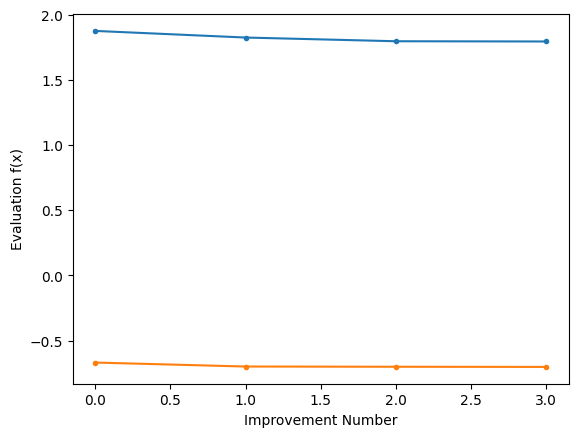

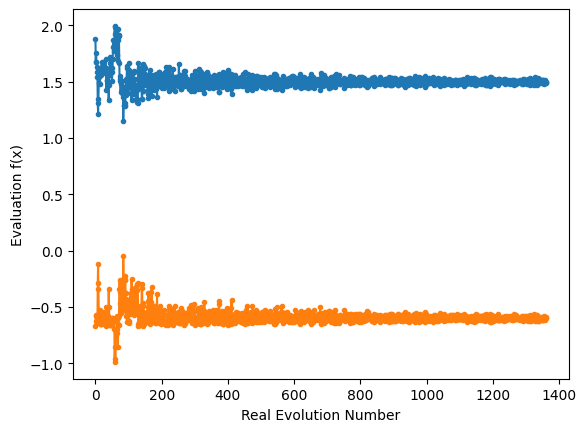

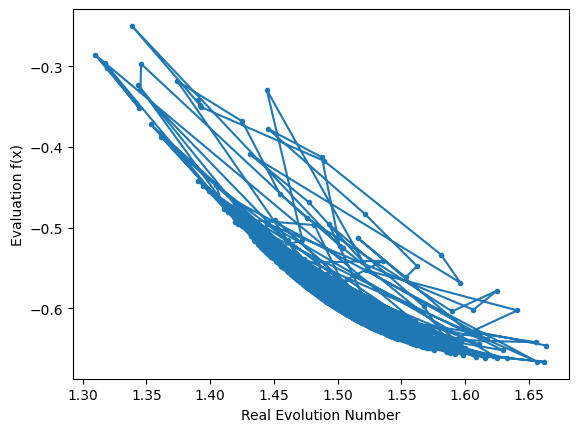

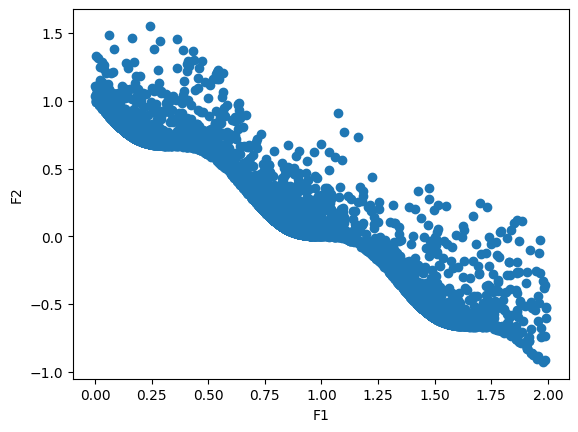

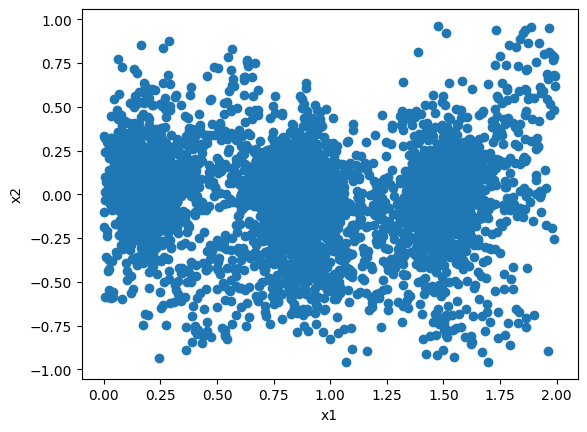

In [ ]:
def F1(x):
    return x[0]

def wrap_F2(a,b):
    def F2(x):
        return 1 - x[0] - a * np.sin(b * np.pi * x[0]) + x[1]**2 
    return F2

####
## non-convex case
####
a=0.1
b=3

F2=wrap_F2(a,b)
objective_list=[F1,F2]




# seed the pseudorandom number generator
#np.random.seed(15)
# define range for input
bounds = np.array([[0, 2],[-1, 1]])
# define the total iterations
n_iterations = 10000
# define the maximum step size
step_size = 0.1
# initial temperature
temp = 10
# perform the simulated annealing search
best, score, hist = MO_simulated_annealing(objective_list, bounds, n_iterations, step_size, temp)

print(f'best point = {best} \nBest objectives={score}')
# line plot of best scores
plt.plot(hist['best'], '.-')
plt.xlabel('Improvement Number')
plt.ylabel('Evaluation f(x)')
plt.show()

plt.plot(hist['scores'], '.-')
plt.xlabel('Real Evolution Number')
plt.ylabel('Evaluation f(x)')
plt.show()

warm_up=100
plt.plot(np.array(hist['scores'])[warm_up:,0],np.array(hist['scores'])[warm_up:,1], '.-')
plt.xlabel('Real Evolution Number')
plt.ylabel('Evaluation f(x)')
plt.show()



runs=20
point_list=[]
score_list=[]
for run in range(runs):
    _ , _, hist = MO_simulated_annealing(objective_list, 
                                          bounds, 
                                          n_iterations, 
                                          step_size, 
                                          temp,
                                          verbose=False)
    point_list.append(hist['points'])
    score_list.append(hist['scores'])
point_list=np.concatenate(point_list,0)
score_list=np.concatenate(score_list,0)

plt.scatter(score_list[:,0],score_list[:,1])
plt.xlabel('F1')
plt.ylabel('F2')
plt.show()

plt.scatter(point_list[:,0],point_list[:,1])
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()